
Based on NLP From Scratch: Generating Names with a Character-Level RNN
*************************************************************
by: `Sean Robertson <https://github.com/spro/practical-pytorch>`_


In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
from random import shuffle
import torch
import torch.nn as nn
from functools import reduce
from collections import Counter
import re
import numpy as np
%matplotlib inline

In [2]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1,nonlinearity='tanh', bias=True, batch_first=False,
                dropout=0, bidirectional=False):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        self.lstm = nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers,nonlinearity=nonlinearity, bias=bias, batch_first=batch_first,
                           dropout=dropout, bidirectional=bidirectional)
#         self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
#         self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)

        self.o2o = nn.Linear(self.num_directions * hidden_size, output_size)
#         self.dropout = nn.Dropout(0.1)
#         self.softmax = nn.Softmax(dim=2)

    def forward(self, my_input, hidden):
#         input_combined = torch.cat((category, input, hidden), 1)
#         hidden = self.i2h(input_combined)
#         output = self.i2o(input_combined)
#         output_combined = torch.cat((hidden, output), 1)
#         output = self.o2o(output_combined)
#         output = self.dropout(output)
        output, hidden = self.lstm(my_input, hidden)
        output = self.o2o(output)
#         output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch=1, device=torch.device('cpu')):
        return torch.zeros(self.num_layers * self.num_directions,1,self.hidden_size, device=device)
#         return torch.zeros(1, self.hidden_size)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bias=True, batch_first=False,
                dropout=0, bidirectional=False):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, bias=bias, batch_first=batch_first,
                           dropout=dropout, bidirectional=bidirectional)
#         self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
#         self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)

        self.o2o = nn.Linear(self.num_directions * hidden_size, output_size)
#         self.dropout = nn.Dropout(0.1)
#         self.softmax = nn.Softmax(dim=2)

    def forward(self, my_input, hidden):
#         input_combined = torch.cat((category, input, hidden), 1)
#         hidden = self.i2h(input_combined)
#         output = self.i2o(input_combined)
#         output_combined = torch.cat((hidden, output), 1)
#         output = self.o2o(output_combined)
#         output = self.dropout(output)
        output, hidden = self.lstm(my_input, hidden)
        output = self.o2o(output)
#         output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch=1, device=torch.device('cpu')):
        return (torch.zeros(self.num_layers * self.num_directions,1,self.hidden_size, device=device), torch.zeros(self.num_layers * self.num_directions,batch,self.hidden_size,device=device))
#         return torch.zeros(1, self.hidden_size)

In [3]:

def string_to_chars(original):
    raw_lines = original.splitlines()

    def proc_line(l): return [l] if l == '<start>' or l == '<end>' else list(l)
    chars = reduce(lambda x, y : x + ['\n'] + y, list(map(proc_line, raw_lines)))
    assert original == ''.join(chars)
    return chars

def make_encoder(raw):
    chars = string_to_chars(raw)
    decoder = [c for c in Counter(chars)]
    decoder = sorted(decoder)
    return {c:i for i, c in enumerate(decoder)}, decoder

def split_songs(raw):
    return re.findall('(<start>.*?<end>)',raw,flags=re.DOTALL)

# train_songs = list(map(string_to_chars, split_songs(raw_train)))

# reconstructed = '\n'.join(map(''.join, train_songs))
# encoder, decoder = make_encoder(raw_train)
# n_chars = len(decoder)

def song_to_tensor_chunks(song,encoder, decoder):
    training_chunks = []
    target_chunks = []
    for i in range(0,len(song),100):
        start = i
        if start+100 > len(song) - 1:
            end = len(song)
            target_range = list(np.arange(start + 1, end,dtype=np.int)) + [int(end - 1)]
        else:
            end = start + 100
            target_range = np.arange(start+1, end+1, dtype=np.int)
        chunk = torch.zeros(end-start, 1, n_chars)
        for i, c in enumerate(song[start:end]):
            chunk[i,0,encoder[c]] = 1
        target_chunk = []
        for i in target_range:
            target_chunk.append(encoder[song[i]])
        target_chunks.append(torch.tensor(target_chunk))
        training_chunks.append(chunk)
    return training_chunks, target_chunks


In [4]:
raw_train = open('train.txt').read()
train_songs = list(map(string_to_chars, split_songs(raw_train)))

reconstructed = '\n'.join(map(''.join, train_songs))
encoder, decoder = make_encoder(raw_train)
n_chars = len(decoder)
val_songs = list(map(string_to_chars, split_songs(open('val.txt').read())))
test_songs = list(map(string_to_chars, split_songs(open('test.txt').read())))
assert reconstructed == raw_train


For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [5]:
criterion = nn.CrossEntropyLoss()

def train(song,optimizer=None, device=torch.device('cpu')):
    train_chunks, target_chunks = song_to_tensor_chunks(song, encoder,decoder)
    hidden = rnn.initHidden(device=device)
    rnn.zero_grad()

    loss = 0

    for input_line_tensor, target_line_tensor in zip(train_chunks,target_chunks):
        target_line_tensor.unsqueeze_(-1)
        for i in range(input_line_tensor.size(0)):
            output, hidden = rnn(input_line_tensor[i].view((1,1,n_chars)).to(device), hidden)
    #         print(output)
            l = criterion(output.view((1,n_chars)), target_line_tensor[i].to(device))
            loss += l / input_line_tensor.size(0)

    loss.backward()
    optimizer.step()

    return output, loss.item() / len(train_chunks)
def test(rnn, song, device=torch.device('cpu')):
    train_chunks, target_chunks = song_to_tensor_chunks(song, encoder,decoder)
    hidden = rnn.initHidden(device=device)
    loss = 0
    for input_line_tensor, target_line_tensor in zip(train_chunks,target_chunks):
        target_line_tensor.unsqueeze_(-1)
        output, hidden = rnn(input_line_tensor.to(device), hidden)
        seq_len,_ =target_line_tensor.size()
        l = criterion(output.view((seq_len,n_chars)), target_line_tensor.view((seq_len)).to(device))
        loss += l
    return output, loss.item() / len(train_chunks)

In [6]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [7]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [8]:
# rnn = RNN(n_chars, 256, n_chars).to(device)
# name='rnn_256'
# version_to_load = 16
# rnn.load_state_dict(torch.load(f'{name}_{version_to_load}.pt'))
# rnn = rnn.to(device)
# train_loss = list(map(float,(open(f'{name}_train_loss_{version_to_load}.csv').read().splitlines())))
# val_loss = list(map(float,(open(f'{name}_val_loss_{version_to_load}.csv').read().splitlines())))
# print(len(train_loss))
# start_epoch = len(train_loss)
# optimizer = torch.optim.Adam(rnn.parameters())

name='Real_rnn_256'
rnn = RNN(n_chars, 256, n_chars).to(device)
rnn = rnn.to(device)
optimizer = torch.optim.Adam(rnn.parameters())
train_loss = []
val_loss = []

start_epoch = 0

In [9]:
# rnn = RNN(n_chars, 128, n_chars).to(device)
learning_rate = 0.05
# optimizer = torch.optim.Adam(rnn.parameters())
n_iters = 10000
print_every = 80
plot_every = 10
# train_loss = []
# val_loss = []
total_loss = 0 # Reset every plot_every iters
n_epochs = 20
start = time.time()

for epoch in range(int(start_epoch),int(start_epoch+n_epochs)):
    shuffle(train_songs)
    total_loss = 0
    for i, song in enumerate(train_songs):
        output, loss = train(song,optimizer=optimizer, device=device)
        total_loss += loss
        if i % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), i, i / len(train_songs) * 100, loss))


    train_loss.append(total_loss / len(train_songs))
    with torch.no_grad():
        total_loss = 0
        for song in test_songs:
            _, loss = test(rnn, song, device=device)
            total_loss += loss
        val_loss.append(total_loss / len(test_songs))
    torch.save(rnn.state_dict(),f'{name}_{epoch}.pt')
    with open(f'{name}_train_loss_{epoch}.csv', 'w+') as out:
        out.write('\n'.join(map(str,train_loss)))

    with open(f'{name}_val_loss_{epoch}.csv', 'w+') as out:
        out.write('\n'.join(map(str,val_loss)))
    print('Epoch %d %s val loss: %.4f train loss: %.4f\n' % (epoch,timeSince(start), val_loss[-1], train_loss[-1]))   
        

0m 0s (0 0%) 4.5545
0m 47s (80 9%) 4.3025
1m 39s (160 19%) 3.7543
2m 24s (240 29%) 2.9947
3m 8s (320 39%) 3.0242
3m 57s (400 49%) 2.7058
4m 38s (480 59%) 2.5840
5m 27s (560 69%) 2.5796
6m 10s (640 79%) 2.3601
6m 55s (720 89%) 2.2395
7m 47s (800 99%) 2.1557
Epoch 0 7m 50s val loss: 2.4502 train loss: 2.9528

7m 50s (0 0%) 2.2302
8m 36s (80 9%) 2.2996
9m 25s (160 19%) 2.2142
10m 13s (240 29%) 2.0775
10m 59s (320 39%) 1.8738
11m 42s (400 49%) 2.6558
12m 35s (480 59%) 2.5364
13m 21s (560 69%) 1.5393
14m 4s (640 79%) 2.1492
14m 52s (720 89%) 2.0018
15m 38s (800 99%) 1.7250
Epoch 1 15m 43s val loss: 2.3261 train loss: 2.2152

15m 43s (0 0%) 1.9435
16m 32s (80 9%) 2.6787
17m 16s (160 19%) 1.7009
18m 4s (240 29%) 3.8890
18m 49s (320 39%) 3.2556
19m 36s (400 49%) 1.6559
20m 22s (480 59%) 2.0400
21m 11s (560 69%) 2.6149
21m 54s (640 79%) 1.7506
22m 41s (720 89%) 1.8676
23m 32s (800 99%) 2.1413
Epoch 2 23m 35s val loss: 1.9820 train loss: 2.0114

23m 36s (0 0%) 2.2123
24m 21s (80 9%) 1.7671
25m 7

[2.9528438598031443, 2.2151647763162448, 2.0113630294484635, 1.860778032240773, 1.7802630450627066, 1.7645563751748048, 1.6678513405999293, 1.6328713515158317, 1.5902879438904487, 1.6136337965947594, 1.5438609421993408, 1.5111104058449396, 1.48661406689443, 1.466830474650111, 1.4547097196262073, 1.551406508325355, 1.4483804386992722, 1.427182520707656, 1.3974729110345834, 1.3931004997673284]
[2.4501790031112645, 2.3260973707847676, 1.981959513981076, 1.925464776147777, 1.9926372568526711, 1.8771435084852737, 1.8782816504358386, 1.834658883529107, 1.8345061652175592, 1.8515540325133606, 1.8130840754056576, 1.8711588833442425, 1.8174669449631375, 1.82164918171186, 1.8009552024747442, 1.903865505466558, 1.8338286399179802, 1.8270820508952257, 1.7845948928037216, 1.806842836515874]


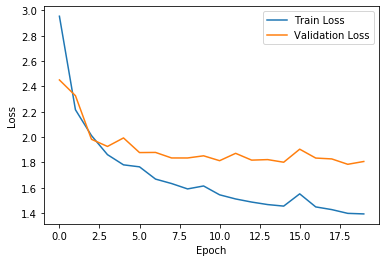

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
offset = 0
epoch_nums = [i for i in range(len(train_loss)+1)]
print(train_loss)
print(val_loss)
with open('train_loss_{offset}.csv', 'w+') as out:
    out.write('\n'.join(map(str,train_loss)))

with open('val_loss_{offset}.csv', 'w+') as out:
    out.write('\n'.join(map(str,val_loss)))
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

In [11]:
# Generates song using temperature of samples
def sample_temp(temperature = 0.8):
    with torch.no_grad():
        input_tensor_chunk, _ = song_to_tensor_chunks(['<start>'], encoder, decoder)
        input_tensor = input_tensor_chunk[0].to(device)
        hidden = rnn.initHidden(device=device)
        prev_char_raw, hidden = rnn(input_tensor,hidden) 
        prev_char_probs = torch.softmax(prev_char_raw, 2, prev_char_raw.dtype).view((n_chars))
        output = '<start>'
        while True:
            output_dist = prev_char_raw.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
            selected_char = decoder[top_i.item()]
            output += selected_char
            input_tensor_chunk, _ = song_to_tensor_chunks([selected_char], encoder, decoder)
            input_tensor = input_tensor_chunk[0].to(device)
            # End song 
            if selected_char == '<end>':
                break
            # Get next letter 
            else:
                prev_char_raw, hidden = rnn(input_tensor,hidden) 
                prev_char_probs = torch.softmax(prev_char_raw, 2, prev_char_raw.dtype).view((n_chars))
        return output
print(sample_temp())

<start>
X:75
T:Le Rinuril Fronka Caerige ow in tou-li--ra cou-re- Joumier duro qui torin The
D G, C, C,,,,,,B,,,C,,,C,,,,,,,,,,,,,,,C,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,, |,,4,,,, D, D, | D,EC|
Z:id:hn-jit-14
M:2/4
L:1/8
K:A
AF FE | A2 FD EC || CE GA | dB/B/ BB | AG FA | B2 B2 Ad AB | BB B2 B2 B2 |
B6 BB GF GB | e6 |
g4d e2e | ded dBA | G3 AAB | e3 dde | d3 : d dB AG | c2 BA GB | BA AF EF ED | EC B, FE B, G, |:
E2 AB AB  | A2AF AGfe | eaga afge | bdga feed |
dfdB A2F | G2B AAB | BGF AGF | ~B3 cAB | ded B2A | GeA dec | ^c2dB ge e2 | g2 fe dc |
<end>


In [12]:
def sample_max(max_length = 1000):
    with torch.no_grad():
        counter = 0
        input_tensor_chunk, _ = song_to_tensor_chunks(['<start>'], encoder, decoder)
        input_tensor = input_tensor_chunk[0].to(device)
        hidden = rnn.initHidden(device=device)
        prev_char_raw, hidden = rnn(input_tensor,hidden) 
        output = '<start>'
        maxarg = torch.argmax(prev_char_raw)
        while True:
            selected_char = decoder[maxarg.item()]
            print('selected_char', selected_char)
            output += selected_char
            input_tensor_chunk, _ = song_to_tensor_chunks([selected_char], encoder, decoder)
            input_tensor = input_tensor_chunk[0].to(device)
            # End of song
            if selected_char == '<end>':
                break
            # Song is repeating and wont end
            if counter == max_length:
                output += '<end>'
                break
            else:
                prev_char_raw, hidden = rnn(input_tensor,hidden) 
                maxarg = torch.argmax(prev_char_raw)
            counter += 1
        return output
print(sample_max())

selected_char 

selected_char X
selected_char :
selected_char 1
selected_char 

selected_char T
selected_char :
selected_char L
selected_char a
selected_char  
selected_char c
selected_char h
selected_char e
selected_char r
selected_char e
selected_char ,
selected_char  
selected_char T
selected_char h
selected_char e
selected_char 

selected_char T
selected_char :
selected_char L
selected_char i
selected_char  
selected_char t
selected_char a
selected_char  
selected_char b
selected_char o
selected_char u
selected_char -
selected_char l
selected_char e
selected_char  
selected_char d
selected_char o
selected_char u
selected_char -
selected_char l
selected_char i
selected_char  
selected_char d
selected_char o
selected_char u
selected_char -
selected_char l
selected_char i
selected_char  
selected_char d
selected_char o
selected_char u
selected_char -
selected_char l
selected_char i
selected_char  
selected_char M
selected_char a
selected_char -
selected_char l
selected_char i
selected

selected_char o
selected_char u
selected_char -
selected_char l
selected_char e
selected_char  
selected_char d
selected_char o
selected_char u
selected_char -
selected_char l
selected_char i
selected_char  
selected_char d
selected_char o
selected_char u
selected_char -
selected_char l
selected_char i
selected_char  
selected_char d
selected_char o
selected_char u
selected_char -
selected_char l
selected_char i
selected_char  
selected_char M
selected_char a
selected_char -
selected_char l
selected_char i
selected_char n
selected_char -
selected_char t
selected_char a
selected_char  
selected_char d
selected_char e
selected_char  
selected_char l
selected_char a
selected_char  
selected_char b
selected_char o
selected_char u
selected_char -
selected_char l
selected_char a
selected_char -
selected_char -
selected_char t
selected_char o
selected_char n
selected_char  
selected_char t
selected_char h
selected_char e
selected_char  
selected_char c
selected_char h
selected_char e
selected

In [13]:
# Normal run 20 epochs
for i in range(6):
    print(sample())

NameError: name 'sample' is not defined

In [ ]:
# hidden size 64 run 16 epochs
for i in range(6):
    print(sample())

In [ ]:
# 20 epochs temp = 1 hidden size = 100
for i in range(6):
    print(sample_temp(.8))